# 프로젝트: GPT-1 논문 기반의 한국어 데이터 챗봇 만들기

## 변경사항

### 전처리 단계
  
    - Unsupervised Pre-training
        - 모델이 다음 토큰을 예측하도록 하나의 문장 데이터를 학습하는 구조
        - 질문, 답변 문장을 연결하지 않고 학습을 위해 row 방향으로 붙여주었다
        - 답변에서 중복 문장들이 많았기에 총 19436개의 데이터를 학습하였다
        - train data의 토큰 길이를 바탕으로 Pre-training에서의 max length는 40으로 설정해줬다
    - Supervised Fine-tuning
        - 질문과 답변 데이터를 구분자 토큰과 함께 하나의 시퀀스로 결합
        - delimiter token 을 추가
        - Supervised Fine-tuning dataset은 기존 pre-training 방식과 데이터셋이 다르게 들어가야한다
        - [[start] 질문 [delimiter] 답 [end]] 구조이므로 길이도 좀 더 길게 설정해줘야한다
        - train data의 토큰 길이를 바탕으로 finetuning에서의 max length는 70으로 설정해줬다

### 모델 구현 단계
    - GPT는 디코더만으로 구성된 트랜스포머 모델이다
    - Encoder-Decoder Attention 제거 :
        - GPT는 디코더만으로 구성되기 때문에 encoder와 비교하는 encoder-decoder Attention Layer가 필요가 없다.
        - 기존 코드에서 두 번째 서브 레이어를 제거한다
        ---------------------------------------------------------------------------------------
                attention2 = MultiHeadAttention(
                    d_model, num_heads, name="attention_2")(inputs={
                          'query': attention1,
                          'key': enc_outputs,
                          'value': enc_outputs,
                          'mask': padding_mask
                      })

                # 마스크드 멀티 헤드 어텐션의 결과는
                # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
                attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
                attention2 = tf.keras.layers.LayerNormalization(
                  epsilon=1e-6)(attention2 + attention1)
       -----------------------------------------------------------------------------------------
    - 인코더 출력 제거 : encoder_outputs 제거
    - 마스킹 방식 : padding mask 제거, look_ahead_mask 만 사용하면됨
    
### 예측 단계
    - input으로 look_ahead_mask 추가해주기
    - 마지막에 end_token이 아니라 delimiter_token을 붙여준다

In [1]:
import os
import re

import pandas as pd
import numpy as np

import tensorflow as tf

In [2]:
chatbot = pd.read_csv('./data/ChatbotData.csv')
chatbot

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


# 데이터 전처리하기
- 공백, 특수문자 처리
- 챗봇 특성상 숫자의 의미가 별로 필요없는 것으로 보이므로 숫자도 제거해준다
    - 옵션을 통해 숫자가 필요하지 않으면 없애는 걸로 코드를 수정했다

In [3]:
# 전처리 함수
def preprocess_sentence(sentence, num=True):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (가-힣, a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    if num == False: # 숫자제거
        sentence = re.sub(r'[^가-힣a-zA-Z.?!,]', ' ', sentence)
    else:
        sentence = re.sub(r'[^가-힣0-9a-zA-Z.?!,]', ' ', sentence)
    sentence = sentence.strip()
    return sentence

In [4]:
sentence = '3박4일 놀러가고 싶다'

In [5]:
preprocess_sentence(sentence)

'3박4일 놀러가고 싶다'

## SubwordTextEncoder 사용하기

- start token, end token, delimiter 토큰을 추가합니다

In [6]:
questions = chatbot.Q.tolist()
answers = chatbot.A.tolist()

In [7]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [8]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN, DELIMITER_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1], [tokenizer.vocab_size + 2]

In [9]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])
print('DELIMITER_TOKEN의 번호 :' ,[tokenizer.vocab_size + 2])

START_TOKEN의 번호 : [8170]
END_TOKEN의 번호 : [8171]
DELIMITER_TOKEN의 번호 : [8172]


In [10]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 3
print(VOCAB_SIZE)

8173


In [11]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5759, 607, 2490, 4160]
정수 인코딩 후의 21번째 답변 샘플: [2353, 7510, 5, 6273, 94, 7960]


### 적절한 패딩 길이 구하기

In [12]:
import matplotlib.pyplot as plt

In [13]:
num_questions = [len(tokens) for tokens in questions]
num_questions = np.array(num_questions)


# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_questions)}")
print(f"토큰 길이 최대: {np.max(num_questions)}")
print(f"토큰 길이 표준편차: {np.std(num_questions)}")

토큰 길이 평균: 12.879049310665652
토큰 길이 최대: 56
토큰 길이 표준편차: 6.167205838440642


In [14]:
num_answers = [len(tokens) for tokens in answers]
num_answers = np.array(num_answers)


# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_answers)}")
print(f"토큰 길이 최대: {np.max(num_answers)}")
print(f"토큰 길이 표준편차: {np.std(num_answers)}")

토큰 길이 평균: 15.0151399813922
토큰 길이 최대: 76
토큰 길이 표준편차: 6.70155143772292


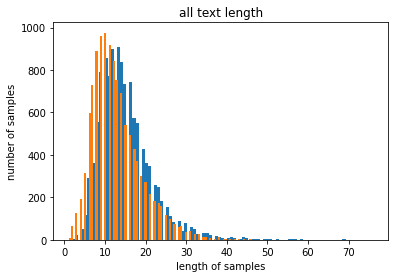

In [15]:
plt.title('all text length')
plt.hist(num_answers, bins=100)
plt.hist(num_questions, bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
select_length = 40

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
        
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [17]:
below_threshold_len(select_length, answers)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9924722997547154


In [18]:
below_threshold_len(select_length, questions)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9984775437706166


In [19]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


# Unsupervised Pre-training

## Unsupervised Pre-training 데이터셋 준비

- train data와 validation data로 나누어서 학습

In [20]:
sentences = pd.concat([chatbot.A, chatbot.Q]).drop_duplicates().tolist()

### 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩

In [21]:
def unsupervised_tokenize_and_filter(inputs):
    tokenized_inputs, tokenized_outputs = [], []

    for sentence in inputs:
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence = START_TOKEN + tokenizer.encode(sentence) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence) <= MAX_LENGTH:
            tokenized_inputs.append(sentence)

    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs

In [22]:
sentences = unsupervised_tokenize_and_filter(sentences)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 문장 샘플 개수: {}'.format(len(sentences)))

단어장의 크기 : 8173
필터링 후의 문장 샘플 개수: 19436


In [23]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [24]:
# look-ahead 마스크 생성
look_ahead_mask = create_look_ahead_mask(sentences[:, :-1])

# BATCH_SIZE와 BUFFER_SIZE 정의
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 질문과 답변 데이터를 tf.data.Dataset으로 만듭니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': sentences[:, :-1],
        'look_ahead_mask': look_ahead_mask,
    },
    {
        'outputs': sentences[:, 1:]
    },
))

# 전체 데이터셋 크기 계산
dataset_size = len(sentences)

# 학습 데이터셋과 검증 데이터셋 크기 계산
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# 데이터셋 캐싱, 셔플링, 배칭 및 prefetch 적용
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)

# 학습 데이터셋과 검증 데이터셋으로 분할
train_dataset = dataset.take(train_size).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = dataset.skip(train_size).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

In [25]:
sentences.shape

(19436, 40)

## Unsupervised Pre-training 모델 구성하기

추가적으로 모델 저장을 위해 `get_config()`와 `__init__`부분을 수정하였다

In [26]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)
    
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0])
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'position': self.position,
            'd_model': self.d_model
        })
        return config

In [27]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

In [28]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs
    
    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
        })
        return config

In [29]:
def gpt_decoder_layer(units, d_model, num_heads, dropout, name="gpt_decoder_layer"):
    
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    
    
    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + inputs)

    # 두 번째 서브 레이어를 제거하고 바로 dense layer로 연결된다
    # 두 번째 서브 레이어 : 2개의 완전연결층 
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention)

    return tf.keras.Model(inputs=[inputs, look_ahead_mask], outputs=outputs, name=name)

def gpt_decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='gpt_decoder'):
    
    # 기존 decoder에 있던 padding mask 제거 (padding mask는 encoder에서 필요했던 것이기 때문)
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = gpt_decoder_layer(units=units, d_model=d_model, num_heads=num_heads, dropout=dropout, 
                                name='gpt_decoder_layer_{}'.format(i))(inputs=[outputs, look_ahead_mask])
    
    logits = tf.keras.layers.Dense(vocab_size, name='outputs')(outputs)

    return tf.keras.Model(inputs=[inputs, look_ahead_mask], outputs=logits, name=name)

In [30]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = gpt_decoder(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "gpt_decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 256)    2092288     inputs[0][0]                     
__________________________________________________________________________________________________
tf.math.multiply (TFOpLambda)   (None, None, 256)    0           embedding[0][0]                  
__________________________________________________________________________________________________
positional_encoding (Positional (None, None, 256)    0           tf.math.multiply[0][0]           
________________________________________________________________________________________

In [31]:
# 손실 함수
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### 커스텀 된 학습률(Learning rate)

$$ lrate = d^{-0.5}_{model} \cdot min(step\_num^{-0.5}, step\_num \cdot warmup\_steps^{-1.5}) $$

In [32]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
    def get_config(self):
        return {
            'd_model': int(self.d_model.numpy()),
            'warmup_steps': self.warmup_steps,
        }

In [33]:
# 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [34]:
# 체크포인트 콜백 정의
checkpoint_path = "./checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델 체크포인트 콜백 생성
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

# 모델 학습
EPOCHS = 10
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint_callback],
    verbose=1
)

Epoch 1/10
243/243 [==============================] - 14s 42ms/step - loss: 1.4455 - accuracy: 0.0210 - val_loss: 1.3196 - val_accuracy: 0.0256

Epoch 00001: val_loss improved from inf to 1.31961, saving model to ./checkpoints/cp-0001.ckpt
Epoch 2/10
243/243 [==============================] - 10s 40ms/step - loss: 1.1988 - accuracy: 0.0295 - val_loss: 1.1125 - val_accuracy: 0.0354

Epoch 00002: val_loss improved from 1.31961 to 1.11253, saving model to ./checkpoints/cp-0002.ckpt
Epoch 3/10
243/243 [==============================] - 10s 40ms/step - loss: 1.1029 - accuracy: 0.0360 - val_loss: 1.0586 - val_accuracy: 0.0389

Epoch 00003: val_loss improved from 1.11253 to 1.05859, saving model to ./checkpoints/cp-0003.ckpt
Epoch 4/10
243/243 [==============================] - 10s 40ms/step - loss: 1.0438 - accuracy: 0.0393 - val_loss: 0.9827 - val_accuracy: 0.0415

Epoch 00004: val_loss improved from 1.05859 to 0.98265, saving model to ./checkpoints/cp-0004.ckpt
Epoch 5/10
243/243 [========

### Loss와 Accuracy 시각화

In [35]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


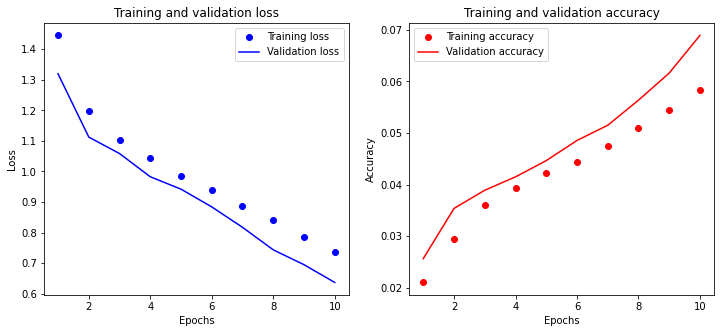

In [36]:
import matplotlib.pyplot as plt

# history에서 손실과 정확도, 검증 손실과 검증 정확도를 추출합니다.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'ro', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 체크포인트 불러오기

In [40]:
# 모델 로드 (구조를 재정의하고 가중치를 로드)
def create_gpt_model():
    return gpt_decoder(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT)

# 모델 인스턴스 생성 및 컴파일
ck_model = create_gpt_model()
ck_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# 체크포인트 콜백 정의
checkpoint_path = "./checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 최신 체크포인트 파일 경로 (예: 마지막 에포크의 체크포인트)
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

# 저장된 가중치를 로드
if latest_checkpoint:
    ck_model.load_weights(latest_checkpoint)
    print(f"Checkpoint loaded: {latest_checkpoint}")
else:
    print("No checkpoint found.")

Checkpoint loaded: ./checkpoints/cp-0010.ckpt


# Supervised fine-tuning

## Supervised Fine-tuning 데이터셋 준비

- train data와 validation data로 나누어서 학습
- Supervised Fine-tuning dataset은 기존 pre-training 방식과 데이터셋이 다르게 들어가야한다
- [[start] 질문 [delimiter] 답 [end]] 구조이므로 길이도 좀 더 길게 설정해줘야한다
- train data의 토큰 길이를 바탕으로 finetuning에서의 max length는 70으로 설정해줬다

In [205]:
data = (chatbot.Q + ' & ' + chatbot.A ).tolist()
data[:5]

['12시 땡! & 하루가 또 가네요.',
 '1지망 학교 떨어졌어 & 위로해 드립니다.',
 '3박4일 놀러가고 싶다 & 여행은 언제나 좋죠.',
 '3박4일 정도 놀러가고 싶다 & 여행은 언제나 좋죠.',
 'PPL 심하네 & 눈살이 찌푸려지죠.']

In [87]:
num_data = [len(tokens) for tokens in data]
num_data = np.array(num_data)


# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_answers)}")
print(f"토큰 길이 최대: {np.max(num_answers)}")
print(f"토큰 길이 표준편차: {np.std(num_answers)}")

토큰 길이 평균: 15.0151399813922
토큰 길이 최대: 76
토큰 길이 표준편차: 6.70155143772292


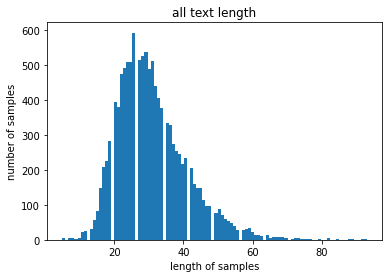

In [89]:
plt.title('all text length')
plt.hist(num_data, bins=100)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [90]:
select_length = 70

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
        
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [93]:
below_threshold_len(select_length, data)

전체 샘플 중 길이가 70 이하인 샘플의 비율: 0.9972934111477628


In [94]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 70
print(MAX_LENGTH)

70


In [99]:
questions = chatbot.Q.tolist()
answers = chatbot.A.tolist()

In [98]:
DELIMITER_TOKEN

[8172]

In [100]:
def tokenize_and_filter(questions, answers):
    tokenized_inputs = []

    for (sentence1, sentence2) in zip(questions, answers):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence = START_TOKEN + tokenizer.encode(sentence1) + DELIMITER_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 70 이하인 경우에만 데이터셋으로 허용
        if len(sentence) <= MAX_LENGTH :
            tokenized_inputs.append(sentence)

    # 최대 길이 80으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs

In [102]:
concate_sentences = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 문장 샘플 개수: {}'.format(len(concate_sentences)))

단어장의 크기 : 8173
필터링 후의 문장 샘플 개수: 11823


In [103]:
concate_sentences.shape

(11823, 70)

In [104]:
concate_sentences

array([[8170, 7909, 4200, ...,    0,    0,    0],
       [8170, 7963,   44, ...,    0,    0,    0],
       [8170, 7965, 1431, ...,    0,    0,    0],
       ...,
       [8170, 8151, 8071, ...,    0,    0,    0],
       [8170,  131,  163, ...,    0,    0,    0],
       [8170, 1948,  881, ...,    0,    0,    0]], dtype=int32)

In [105]:
# look-ahead 마스크 생성
look_ahead_mask = create_look_ahead_mask(concate_sentences[:, :-1])

In [106]:
concate_sentences.shape

(11823, 70)

In [107]:
look_ahead_mask.shape

TensorShape([11823, 1, 69, 69])

In [108]:
# BATCH_SIZE와 BUFFER_SIZE 정의
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 질문과 답변 데이터를 tf.data.Dataset으로 만듭니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': concate_sentences[:, :-1],
        'look_ahead_mask': look_ahead_mask,
    },
    {
        'outputs': concate_sentences[:, 1:]
    },
))

# 전체 데이터셋 크기 계산
dataset_size = len(concate_sentences)

# 학습 데이터셋과 검증 데이터셋 크기 계산
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# 데이터셋 캐싱, 셔플링, 배칭 및 prefetch 적용
dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)

# 학습 데이터셋과 검증 데이터셋으로 분할
train_dataset = dataset.take(train_size).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = dataset.skip(train_size).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

## Supervised fine-tuning 모델 정의
- 문장 단위로 학습했던 모델 기반으로 finetuning을 진행한다
- pretrain 모델의 weight를 fine-tuning model로 불러왔다

In [109]:
def gpt_supervised_finetuning(vocab_size, num_layers, units, d_model, num_heads, dropout):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = gpt_decoder_layer(units=units, d_model=d_model, num_heads=num_heads, dropout=dropout, 
                                    name='gpt_decoder_layer_{}'.format(i))(inputs=[outputs, look_ahead_mask])
    
    outputs = tf.keras.layers.Dense(vocab_size, name='outputs')(outputs)
    
    return tf.keras.Model(inputs=[inputs, look_ahead_mask], outputs=outputs, name='gpt_supervised_finetuning')

In [110]:
max_length_finetune = 70

# Supervised Fine-tuning 모델 생성
finetune_model = gpt_supervised_finetuning(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

finetune_model.summary()

Model: "gpt_supervised_finetuning"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 256)    2092288     inputs[0][0]                     
__________________________________________________________________________________________________
tf.math.multiply_6 (TFOpLambda) (None, None, 256)    0           embedding_6[0][0]                
__________________________________________________________________________________________________
positional_encoding_6 (Position (None, None, 256)    0           tf.math.multiply_6[0][0]         
__________________________________________________________________________

In [111]:
# 모델 컴파일
finetune_model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
# fine-tuning model로 weight을 불러옴
## 이부분은 생각보다 성능이 좋지 않아서 아래 코드는 빼고 학습을 진행했다
for i in range(NUM_LAYERS):
    finetune_model.get_layer(f'gpt_decoder_layer_{i}').set_weights(
        model.get_layer(f'gpt_decoder_layer_{i}').get_weights()
    )

finetune_model.get_layer('embedding_2').set_weights(model.get_layer('embedding').get_weights())
finetune_model.get_layer('positional_encoding_2').set_weights(model.get_layer('positional_encoding').get_weights())

In [112]:
# 체크포인트 콜백 정의
checkpoint_path = "./finetune_checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델 체크포인트 콜백 생성
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

# 모델 학습
EPOCHS = 10
history = finetune_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint_callback],
    verbose=1
)

Epoch 1/10
148/148 [==============================] - 13s 68ms/step - loss: 1.2423 - accuracy: 0.0428 - val_loss: 1.1039 - val_accuracy: 0.0480

Epoch 00001: val_loss improved from inf to 1.10389, saving model to ./finetune_checkpoints/cp-0001.ckpt
Epoch 2/10
148/148 [==============================] - 10s 65ms/step - loss: 1.0651 - accuracy: 0.0506 - val_loss: 0.9685 - val_accuracy: 0.0545

Epoch 00002: val_loss improved from 1.10389 to 0.96846, saving model to ./finetune_checkpoints/cp-0002.ckpt
Epoch 3/10
148/148 [==============================] - 10s 65ms/step - loss: 0.9642 - accuracy: 0.0570 - val_loss: 0.8759 - val_accuracy: 0.0641

Epoch 00003: val_loss improved from 0.96846 to 0.87588, saving model to ./finetune_checkpoints/cp-0003.ckpt
Epoch 4/10
148/148 [==============================] - 10s 66ms/step - loss: 0.8742 - accuracy: 0.0640 - val_loss: 0.7818 - val_accuracy: 0.0720

Epoch 00004: val_loss improved from 0.87588 to 0.78183, saving model to ./finetune_checkpoints/cp-00

### Loss와 Accuracy 시각화

In [113]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


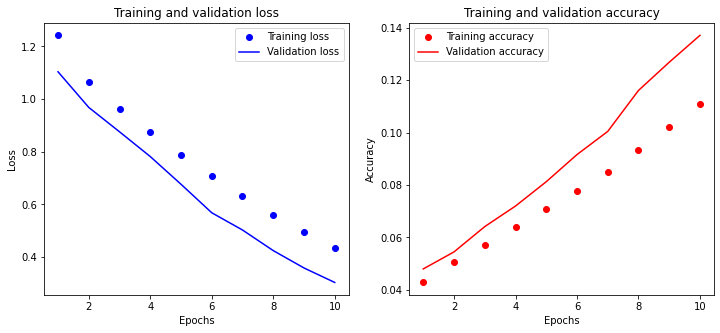

In [114]:
import matplotlib.pyplot as plt

# history에서 손실과 정확도, 검증 손실과 검증 정확도를 추출합니다.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'ro', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 모델 평가하기

In [194]:
def decoder_inference(sentence, model, tokenizer, max_length):
    # 문장 전처리
    sentence = preprocess_sentence(sentence)

    # 토큰화한 후에 뒤에 DELIMITER_TOKEN을 붙여줌
    input_sequence = tf.constant(START_TOKEN + tokenizer.encode(sentence) + DELIMITER_TOKEN)

    input_sequence = tf.expand_dims(input_sequence, axis=0)  # Shape: (1, seq_length)

    # look-ahead mask를 input으로 넣어줘야 하기에 이를 추가해준다
    look_ahead_mask = create_look_ahead_mask(input_sequence)

    # DELIMITER_TOKEN으로 output을 초기화
    output_sequence = tf.constant([DELIMITER_TOKEN])

    for _ in range(max_length):
        # 다음 토큰을 예측
        predictions = model(inputs=[input_sequence, look_ahead_mask], training=False)
        predictions = predictions[:, -1:, :]

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if tf.equal(predicted_id, END_TOKEN):
            break

        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

        input_sequence = tf.concat([input_sequence, predicted_id], axis=-1)
        look_ahead_mask = create_look_ahead_mask(input_sequence)

    output_sequence = tf.squeeze(output_sequence, axis=0)
    predicted_sentence = tokenizer.decode([i for i in output_sequence.numpy() if i < tokenizer.vocab_size])

    return predicted_sentence


In [195]:
def sentence_generation(sentence, model, tokenizer, max_length):
    predicted_sentence = decoder_inference(sentence, model, tokenizer, max_length)

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence


## 테스트 및 평가

- 기존에 transformer 모델보다 일반화 성능이 더 좋은 것으로 보인다
- 시간상의 이유로 10 epoch을 하였음에도 기존에 transformer는 10 epoch 수행시 엉뚱한 말만 했는데 어울리는 말을 잘 하는 것을 볼 수 있다

In [196]:
sentence_generation('나 오늘 헤어졌어', finetune_model, tokenizer, max_length=50)

입력 : 나 오늘 헤어졌어
출력 : 좀 더 기다려주세요.


'좀 더 기다려주세요.'

In [197]:
sentence_generation('좋아하는 사람 생겼어', finetune_model, tokenizer, max_length=50)

입력 : 좋아하는 사람 생겼어
출력 : 마음이 허락하는 말인 관계인가봐요.


'마음이 허락하는 말인 관계인가봐요.'

In [198]:
sentence_generation("오늘 날씨 좋다", finetune_model, tokenizer, max_length=50)

입력 : 오늘 날씨 좋다
출력 : 오늘 강추위래요.


'오늘 강추위래요.'

In [203]:
sentence_generation("여행 가고 싶어", finetune_model, tokenizer, max_length=50)

입력 : 여행 가고 싶어
출력 : 좋은 생각이에요.


'좋은 생각이에요.'

# 회고

- 배운 점 
    - 논문을 읽고 이를 바탕으로 GPT 모델을 직접 구현해볼 수 있었다
- 아쉬운 점 
    - Unsupervised pre-training 단계에서 좀 더 다양한 문장들을 실험해보면 좋을 것 같았다
    - 데이터셋이 적어서 pretrain weight를 불러오는게 오히려 성능이 좋지 않았다
- 느낀 점
    - 어려운 개념이라도 노력하면 이해할 수 있다는 것을 느꼈다
    - transformer보다도 일반화 성능이 잘 되는 것 같았다
- 어려웠던 점 
    - 직접 구현하는 과정에서 모델 shape를 맞추는 것이 생각보다 까다로웠다
    - 오히려 기존 코드를 수정하는 과정에서 오류가 많이 났다